##  Traffic Forecasting Using Fine-Tuned Time Mixture of Experts (Time-MoE) for Optimizing Urban Flow via Adaptive Signal Control

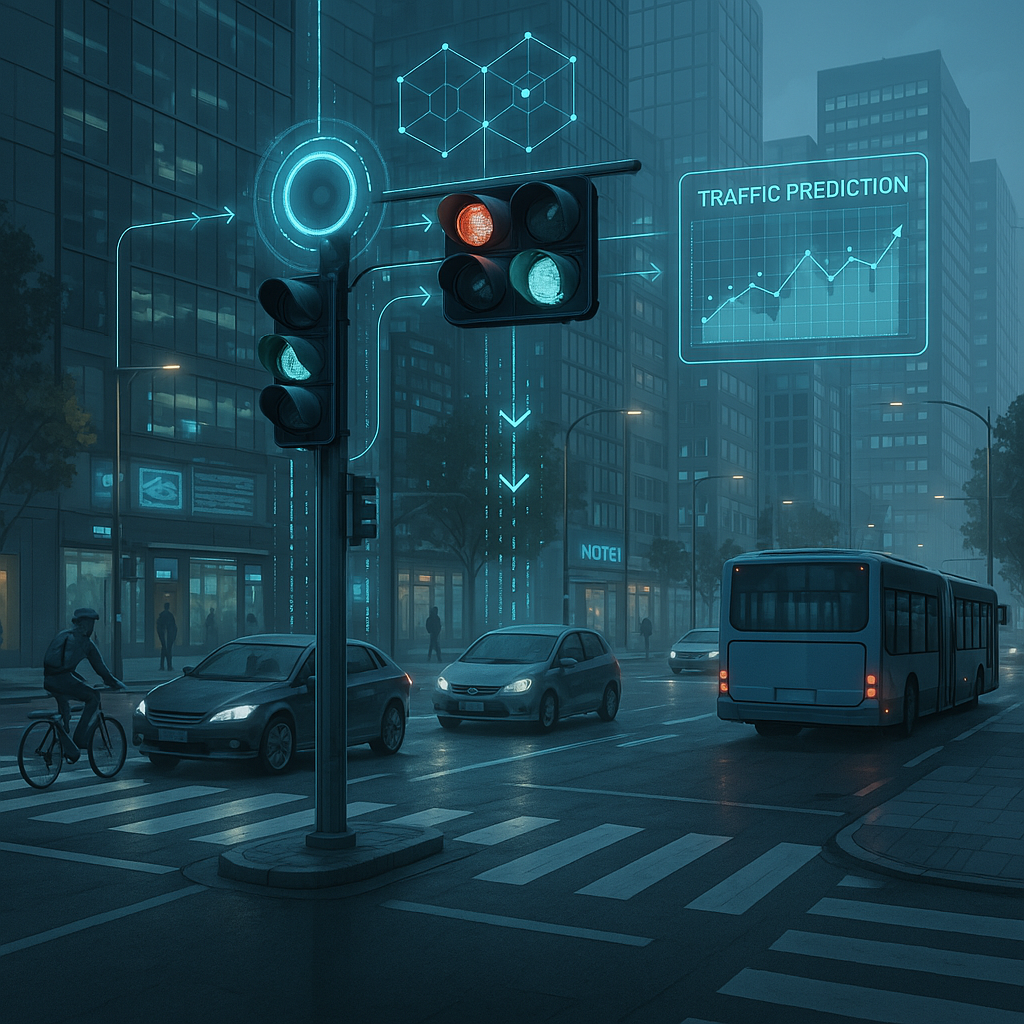

### Introduction <a id='Introduction'></a>

Efficient urban traffic management is a critical component of a smart city for supporting its intelligent transportation systems, especially in the context of increasing vehicular density and dynamic traffic patterns. Traditional fixed-time and actuated signal control strategies often fail to adapt to real-time fluctuations in traffic demand, leading to suboptimal phase timing, increased queue lengths, and travel delays. This study demonstrates a AI driven framework that fine-tunes a Time-MoE (Mixture of Experts) model for short-term traffic flow forecasting at 15-minute intervals, with the goal of enabling adaptive traffic signal control at urban intersections.

The proposed system uses historical traffic volume data as inputs to predict vehicular flow across 6 different multiple traffic intersection for a full day at 15 minutes interval. These forecasts are then used to dynamically adjust signal timing parameters such as green splits, cycle lengths, and phase sequences within a coordinated traffic signal control system. By aligning predictive analytics with adaptive signal control logic, the framework aims to minimize intersection delay, reduce vehicle waiting time, and improve overall urban network flow.

### Imports <a id='Necessary-Imports'></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

from datetime import datetime as dt
from IPython.display import Image, HTML
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from arcgis.gis import GIS
from arcgis.learn import TimeSeriesModel, prepare_tabulardata

### Connecting to ArcGIS

In [2]:
gis = GIS("home")

### Accessing the data <a id='Accessing-the-King-County-dataset-for-housing-prediction'></a>

The dataset comprises vehicular traffic volume counts recorded at six distinct urban intersection at 15-minute intervals, with a total of 96 observations per day. The complete dataset consists of a total of 5,376 time-stamped data points, representing continuous traffic flow monitoring over several days. The following cell downloads the data:

In [3]:
data_table = gis.content.get("3583aaf89daf405ba59a8bd86ce795ca")
data_table

<Item title:"traffic_data" type:CSV owner:demos_deldev>

In [4]:
# Download the csv and saving it in local folder
data_path = data_table.get_data()

In [5]:
# # Read the csv file
six_junction_traffic_count_new = pd.read_csv(data_path).drop(["Unnamed: 0"], axis=1)
six_junction_traffic_count_new['Datetime'] = pd.to_datetime(six_junction_traffic_count_new['Datetime'])
six_junction_traffic_count_new.head(5)

,Index,Datetime,Cross 1,Cross 2,Cross 3,Cross 4,Cross 5,Cross 6
0,0,2015-11-01 00:00:00,278.0,136.0,106.0,175.0,113.0,313.0
1,1,2015-11-01 00:15:00,265.0,121.0,121.0,171.0,112.0,305.0
2,2,2015-11-01 00:30:00,263.0,132.0,95.0,149.0,81.0,280.0
3,3,2015-11-01 00:45:00,184.0,97.0,58.0,148.0,67.0,163.0
4,4,2015-11-01 01:00:00,161.0,67.0,59.0,108.0,57.0,166.0


In [6]:
six_junction_traffic_count_new.shape

(5376, 8)

In [7]:
six_junction_traffic_count_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Index     5376 non-null   int64         
 1   Datetime  5376 non-null   datetime64[ns]
 2   Cross 1   5376 non-null   float64       
 3   Cross 2   5376 non-null   float64       
 4   Cross 3   5376 non-null   float64       
 5   Cross 4   5376 non-null   float64       
 6   Cross 5   5376 non-null   float64       
 7   Cross 6   5376 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 336.1 KB


### Data processing

Data processing for a timeseries consists of first splitting the dataset into a training dataset and a testing dataset as follows:

### Train - Test split of timeseries dataset 

Here we will forecast vehilce counts at six junctions every 15 minutes for an entire day, resulting in 96 data points. To validate the model, we will set aside these 96 data points as the test set, while the remaining data will be used for training.

In [8]:
test_size = 96
train, test = train_test_split(six_junction_traffic_count_new, test_size = test_size, shuffle=False)

In [9]:
train.tail(5)

,Index,Datetime,Cross 1,Cross 2,Cross 3,Cross 4,Cross 5,Cross 6
5275,5275,2015-12-25 22:45:00,301.0,162.0,163.0,245.0,157.0,309.0
5276,5276,2015-12-25 23:00:00,325.0,154.0,236.0,320.0,236.0,331.0
5277,5277,2015-12-25 23:15:00,325.0,177.0,185.0,284.0,185.0,288.0
5278,5278,2015-12-25 23:30:00,255.0,139.0,122.0,196.0,144.0,272.0
5279,5279,2015-12-25 23:45:00,179.0,80.0,97.0,127.0,99.0,225.0


In [10]:
train.shape

(5280, 8)

In [11]:
# check the columns 
train.columns

Index(['Index', 'Datetime', 'Cross 1', 'Cross 2', 'Cross 3', 'Cross 4',
       'Cross 5', 'Cross 6'],
      dtype='object')

### Autocorrelation plot

While deep learning models can learn complex patterns automatically, ACF plots remain a valuable exploratory tool for understanding the data, identify how strongly past time steps influence future values, guiding the selection of input sequence length for model design, detecting seasonality (periodic occurrences of peaks and troughs for example) and lag patterns, and validating results.

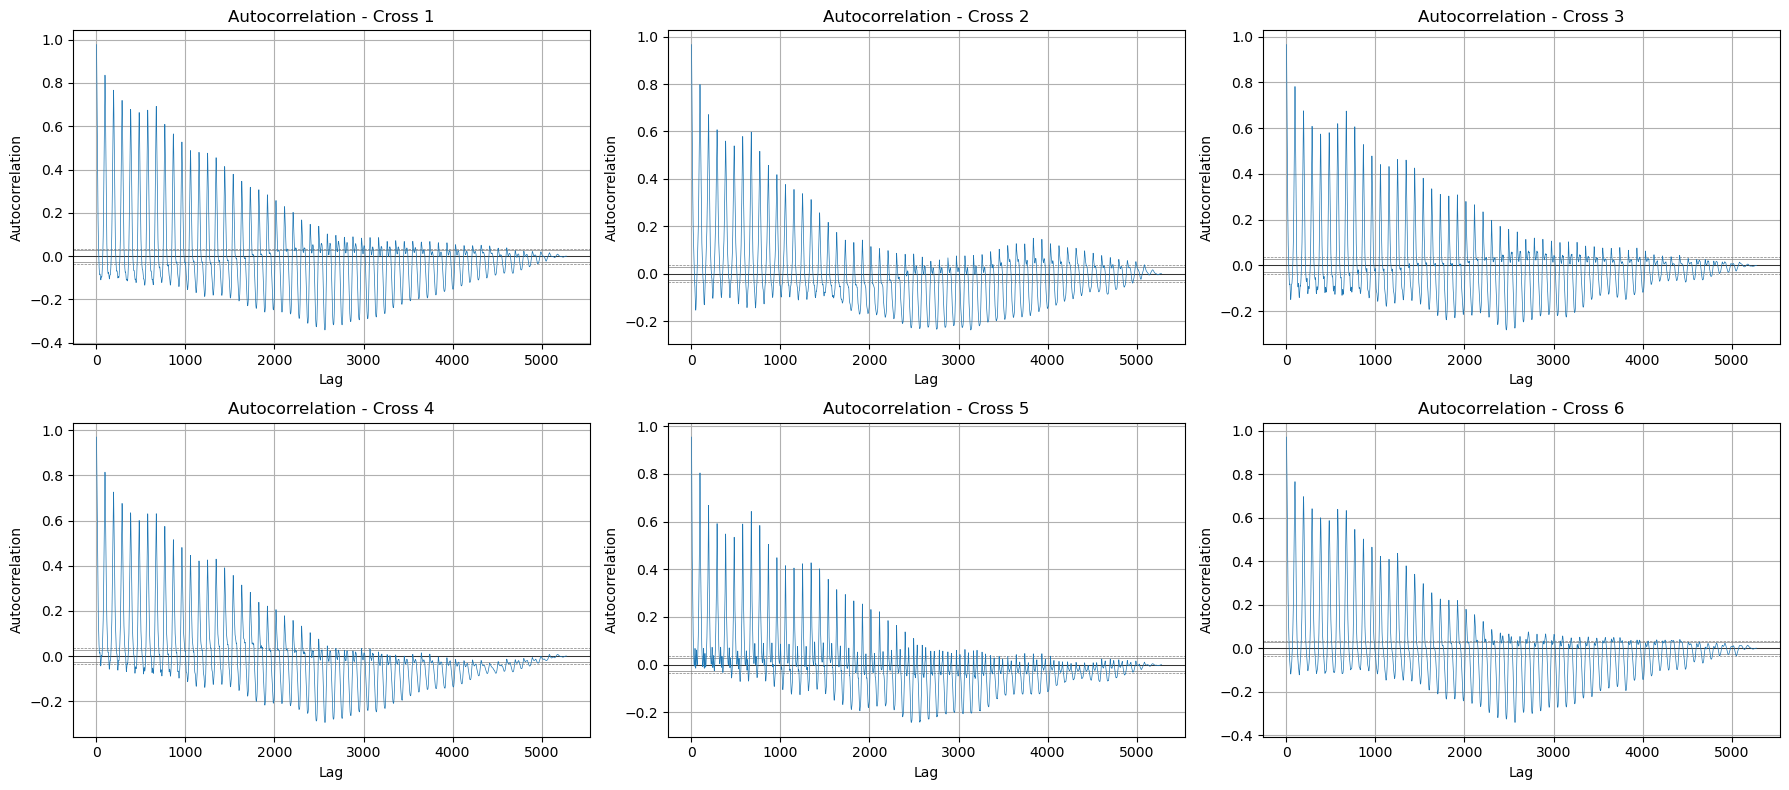

In [12]:
cross_columns = [col for col in train.columns if col.startswith('Cross')]
num_plots = len(cross_columns)
cols = 3  
rows = (num_plots + cols - 1) // cols
plt.figure(figsize=(cols * 6, rows * 4))

# Generate autocorrelation plots
for i, col in enumerate(cross_columns, 1):
        plt.subplot(rows, cols, i)
        ax = plt.gca()
        autocorrelation_plot(train[col], ax=ax)
        for line in ax.lines:
            line.set_linewidth(0.5)
        plt.title(f'Autocorrelation - {col}')
plt.tight_layout()
plt.show()

The ACF plots for all six traffic intersections indicate a strong positive autocorrelation at lag-1, which gradually decays as the lag increases. This pattern suggests that the traffic volume at each intersection is highly dependent on its recent past values, a characteristic typical of stationary or near-stationary time series. Such autocorrelation structures confirm the suitability of these series for time series forecasting models, including both statistical and deep learning approaches.

### Model Building <a class="anchor" id="8"></a> 

After the ACF plots validate the data's suitability for the time series, the training data is then prepared for modeling. To demonstrate the complete workflow including data praparation, model initilaization, training, forecasting, and validation using Time-MoE, we will select crossing 3 from the six available crossings.

#### Data Preparation <a class="anchor" id="9"></a> 

In this method, we are using univariates of vehicle counts to forecast the 96 timesteps of future vehicle counts for every 15 minutes based on historical data. We will be usedng the one step univariate method to train the model and will preprate the data.

In this method, we perform univariate time series forecasting to forecast the next 96 time steps, accounting for 24 hours of future vehicle counts at 15-minute intervals using only the historical values of vehicle counts. This setup follows a one-step univariate forecasting approach where the model is trained to predict one time step ahead, then iteratively forecast multiple steps.

The dataset is preprocessed using the `prepare_tabulardata` function from the `arcgis.learn` module in the ArcGIS API for Python. This function will take either a non spatial dataframe, a feature layer, or a spatial dataframe containing the dataset as input and will return a TabularDataObject that can be fed into the model. Here, we use a non-spatial DataFrame as input that contains time-stamped vehicle count data for each intersection. 

The key input parameters required for the tool are:

- <span style='background :lightgrey' >input_features</span> : non spatial dataframe, containing the primary dataset. 
- <span style='background :lightgrey' >variable_predict</span> : The target variable field name `Cross 1`,`Cross 2` etc.,  representing the vehicle count to be forecasted.
- <span style='background :lightgrey' >explanatory_variables</span> : Not used in this univariate setup. 
- <span style='background :lightgrey' >index_field</span> : The timestamp column, which serves as the temporal index for the time series.

Here, preprocessors are used to apply data normalization or standardization (e.g., MinMaxScaler or StandardScaler). Scaling is a common practice in deep learning to improve model convergence and performance, especially when using models that are sensitive to the scale of input features.

In [13]:
# Data preparation for cross 3
preprocessors = [("Cross 3", MinMaxScaler())] 

data = prepare_tabulardata(train, 
                           variable_predict="Cross 3",
                           index_field="DateTime", 
                           preprocessors=preprocessors)

Index field is not timestamp. Converting it to timestamp.


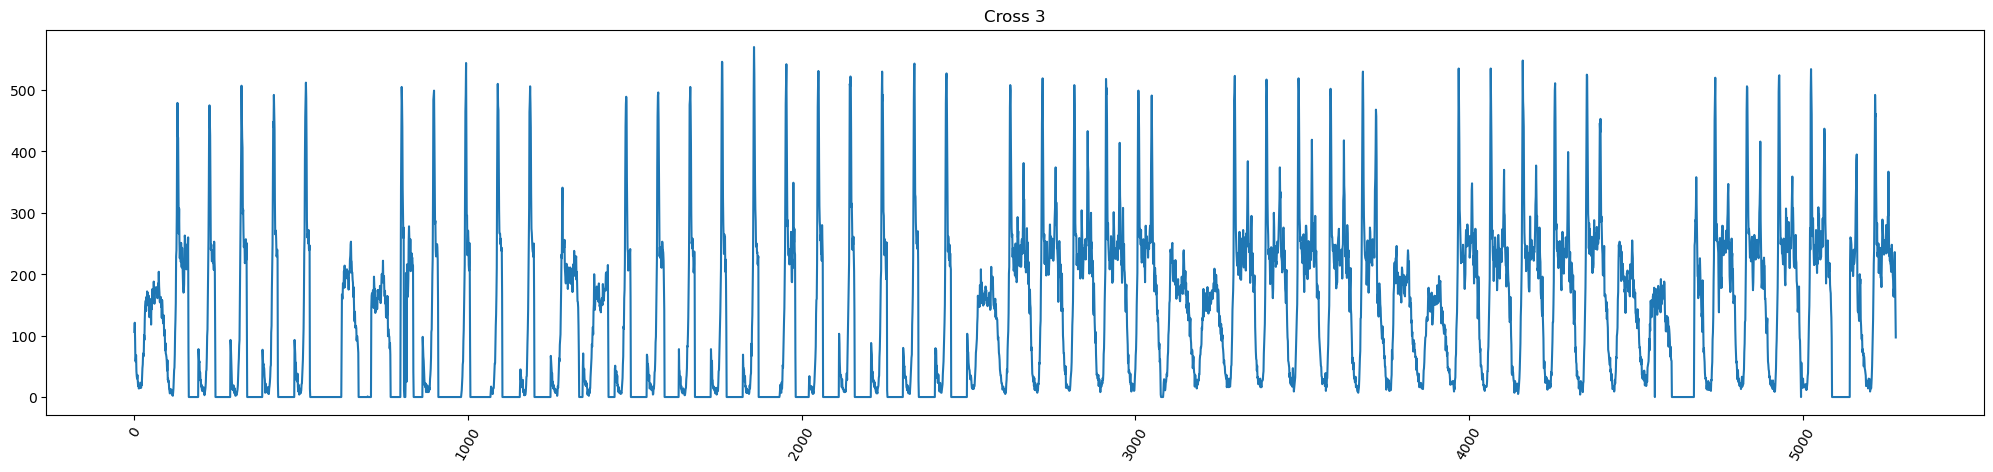

In [14]:
# Visualize the entire timeseries data for crossing 3
data.show_batch(graph=True)

From the plot above, we can see that in these urban traffic datasets collected at high temporal resolution, every 15 minutes in this case, there are frequent zero or near-zero vehicle counts, particularly during off-peak hours like late at night or early in the morning. These low-activity periods introduce sparsity and non-uniform temporal patterns, which can pose challenges for time series forecasting models, especially deep learning models that rely on learning temporal dependencies. Such sparsity also introduces challenges for time series modeling, as it can lead to non-stationarity, class imbalance, and difficulty in capturing temporal dynamics. These characteristics must be carefully addressed during model training, especially when using deep learning architectures like LSTM, Transformer-based models, that are sensitive to the distribution and continuity of input sequences. This is where fine-tuning a pretrained backbone allows the model to adapt to the specific characteristics of traffic datasets, like sparsity during off-peak hours, while retaining robust general features.

Here we can utilize the `show_batch()` function both for inspection and visualization. First, we use it to display the vehicle counts, where each time series data instance is identified by an index corresponding to its specific datetime. 

In [15]:
data.show_batch()

,Cross 3
453,0.0
1115,0.0
2292,0.0
4155,131.0
5074,249.0


Next, the sequence length of 576 is used, as it is the past 6 days of vehicle counts. This is an important parameter for fitting a timeseries forecasting model and usually indicates the seasonality of the data, which can be experimented with for a better fit.

Index field is not timestamp. Converting it to timestamp.


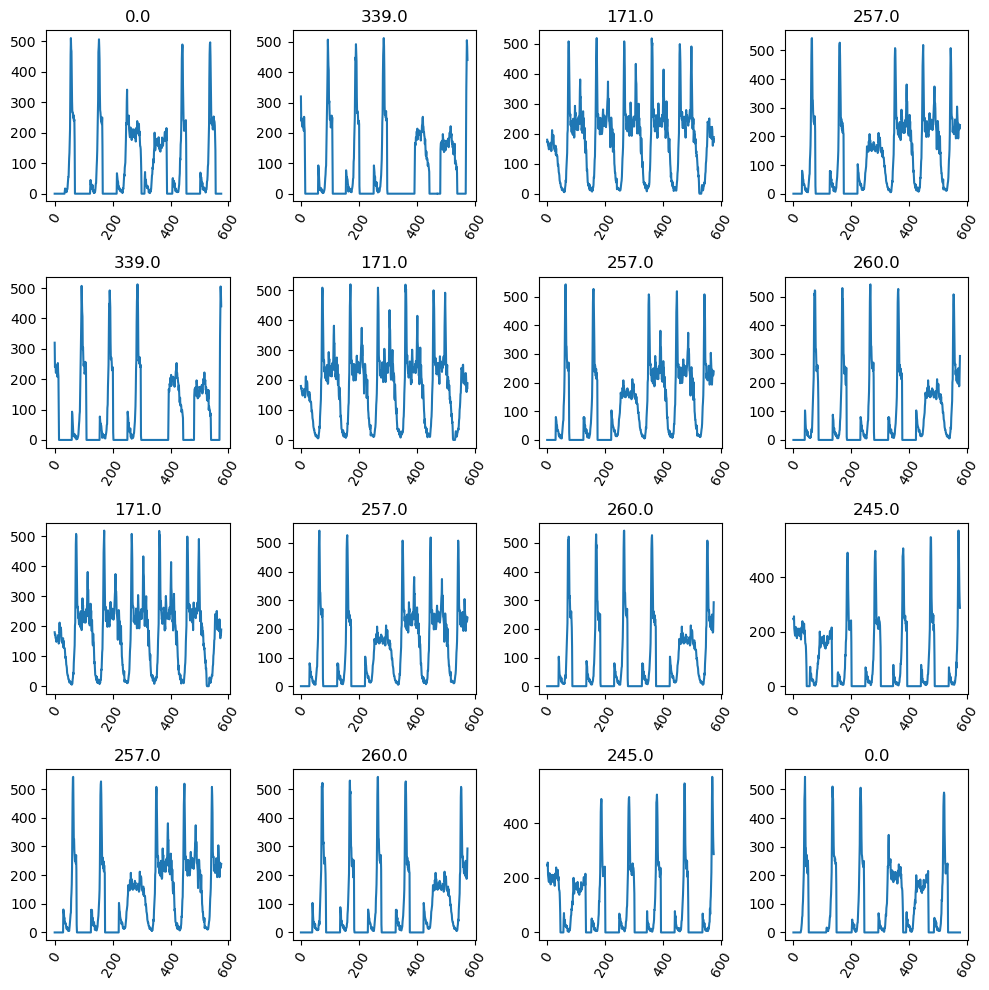

In [16]:
seq_len = 576
data.show_batch(rows=4,seq_len=seq_len)

#### Model Initialization <a class="anchor" id="10"></a>

For model initialization, the preprocesed data, the backbone for training the model, and the sequence length are passed as parameters. The sequence length is a critical paramter and should be selected carefully. The sequence length is usually the perioicity of the data. You can experiment with different sequence lengths, given sufficient computing resources are available.

In terms of backbones the available set of backbones encompasses various architectures specialized for handling time series data. Here we will chose the pretrained `Time-MoE` backbone for fine tuning.

In [17]:
train.columns

Index(['Index', 'Datetime', 'Cross 1', 'Cross 2', 'Cross 3', 'Cross 4',
       'Cross 5', 'Cross 6'],
      dtype='object')

In [17]:
seq_len = 576
ts_model = TimeSeriesModel(data, seq_len=seq_len, model_arch='TimeMOE')

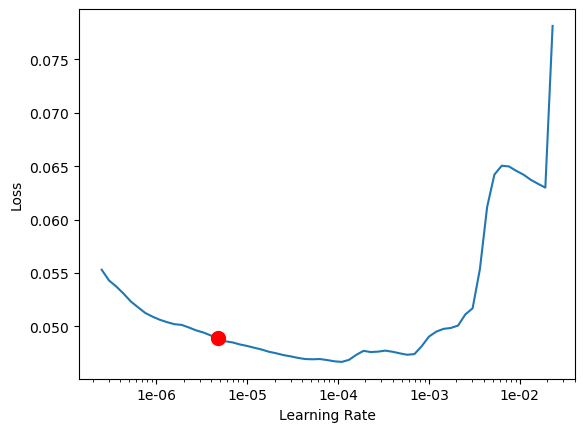

4.7863009232263826e-06

In [18]:
# Finding the learning rate for training the model
l_rate = ts_model.lr_find()
l_rate

### Model training 

The model is now ready for training. The training process is initiated using the `model.fit()` function, where we specify the number of training epochs and the learning rate. The learning rate is selected based on the optimal value suggested by `the lr_find()` method, which helps identify a suitable range for stable and efficient convergence.

Since the model is pretrained, we use 25 epochs for fine-tuning. This number was determined afer running a few iteration and found to be sufficient for convergence without overfitting. Extending training beyond this point may lead to overfitting, as the model has already learned general temporal patterns from pretraining and only requires task-specific adaptation to the traffic dataset.

In [19]:
# time-moe - cross 2
ts_model.fit(25, lr=l_rate)

epoch,train_loss,valid_loss,time
0,0.045376,0.043533,01:21
1,0.043359,0.042693,01:22
2,0.042629,0.042408,01:22
3,0.042297,0.041879,01:22
4,0.042110,0.042032,01:22
5,0.041991,0.041720,01:21
6,0.041990,0.041577,01:21
7,0.041841,0.041665,01:22
8,0.041836,0.041534,01:22
9,0.041816,0.041900,01:22


In [20]:
# check the trained model score for cross 2
ts_model.score()

0.7439056568782875

Next, we will use show result to compare the actual vs the forecasted value to understand the performance of the model. The value on the top of the left side graphs signifies the actual target variable for forecasting, and closely matches the forecasted values, indicating a good fit. This is a further validaion of the model score above. 

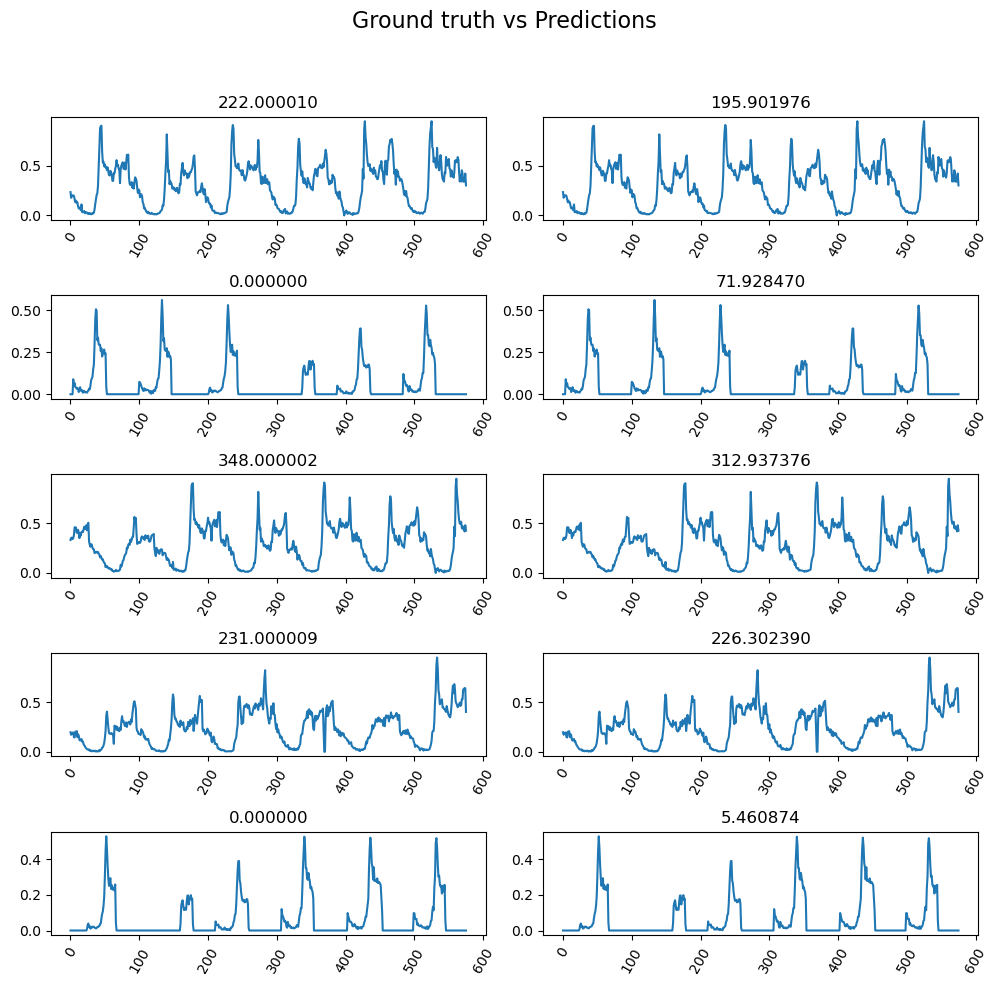

In [21]:
# the ground truth vs the predicted values by the trained model is visualized to check the quality of the trained model
ts_model.show_results(rows=5)

### Traffic forecast & validation 

Now, to ensure the model's effectiveness, the trained model is used to forecast traffic. First, we forecast for 96 future timestamps, at 15 minutes interval (15 minutes × 96 = 24 hours), thus covering one whole day, starting on 00:00:00, 00:15:00, 00:30:00 etc., until 23:45:00 of the same day. 

In [22]:
test_size = 96
# The forecast is returned as a dataframe 
sdf_forecasted_univar = ts_model.predict(train, prediction_type='dataframe', number_of_predictions=test_size)

In [23]:
# checking the final forecasted result returned by the model
sdf_forecasted_univar.tail(2)

,Index,Datetime,Cross 1,Cross 2,Cross 3,Cross 4,Cross 5,Cross 6,Cross 2_results
5374,NaN,2015-12-26 23:30,NaN,NaN,NaN,NaN,NaN,NaN,90.825362
5375,NaN,2015-12-26 23:45,NaN,NaN,NaN,NaN,NaN,NaN,86.091224


In [24]:
test.head()

,Index,Datetime,Cross 1,Cross 2,Cross 3,Cross 4,Cross 5,Cross 6
5280,5280,2015-12-26 00:00:00,165.0,102.0,90.0,131.0,90.0,172.0
5281,5281,2015-12-26 00:15:00,140.0,61.0,56.0,105.0,69.0,170.0
5282,5282,2015-12-26 00:30:00,134.0,78.0,57.0,107.0,75.0,158.0
5283,5283,2015-12-26 00:45:00,94.0,57.0,39.0,79.0,70.0,126.0
5284,5284,2015-12-26 01:00:00,119.0,52.0,44.0,75.0,56.0,119.0


Next, the predicted values are then validated against the actual observed vehicle counts to assess the model’s accuracy and generalization capability. This step is crucial for verifying the model's effectiveness in capturing temporal patterns and producing reliable forecasts in real-world traffic scenarios.

In [25]:
# Formating the forecasted result into actual vs the predicted columns
sdf_forecasted = sdf_forecasted_univar.tail(test_size).copy()
sdf_forecasted = sdf_forecasted[['Datetime','Cross 2_results']]
sdf_forecasted['Actual Cross 2 Vehicle Count'] = test['Cross 2'].values
sdf_forecasted = sdf_forecasted.set_index(sdf_forecasted.columns[0])
sdf_forecasted.head()

,Cross 2_results,Actual Cross 2 Vehicle Count
Datetime,,
2015-12-26 00:00,108.371693,102.0
2015-12-26 00:15,106.842910,61.0
2015-12-26 00:30,76.686336,78.0
2015-12-26 00:45,71.091653,57.0
2015-12-26 01:00,74.355400,52.0


In [26]:
sdf_forecasted.shape

(96, 2)

#### Validation score

In [27]:
y_true = sdf_forecasted['Actual Cross 2 Vehicle Count']
y_pred = sdf_forecasted['Cross 2_results']

r2_test = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f'R-Squared: {r2_test:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')

R-Squared: 0.82
Root Mean Squared Error (RMSE): 73.41
Mean Absolute Error (MAE): 55.68


In [27]:
y_true = sdf_forecasted['Actual Cross 1 Vehicle Count']
y_pred = sdf_forecasted['Cross 1_results']

r2_test = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f'R-Squared: {r2_test:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')

R-Squared: 0.88
Root Mean Squared Error (RMSE): 85.18
Mean Absolute Error (MAE): 66.36


A considerably high R-Squared and corresponding low RMSE and MAE values indicates a high similarity between the forecasted and the actual sales values.

### Actual vs. forecast visualization

The trained model's performance is evaluated by plotting actual versus forecasted values over the 96 timesteps, allowing a clear visual comparison to quickly assess forecasting accuracy.

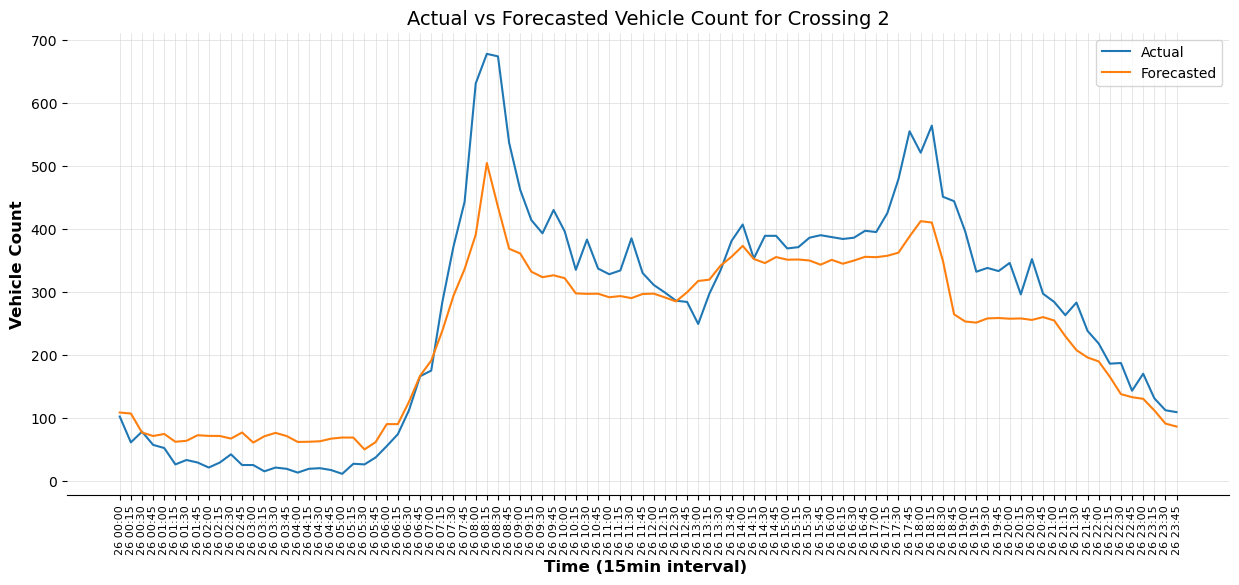

In [28]:
# Plotting
if isinstance(sdf_forecasted.index, pd.PeriodIndex):
    sdf_forecasted.index = sdf_forecasted.index.to_timestamp()
    
plt.figure(figsize=(15, 6))
plt.plot(sdf_forecasted.index, sdf_forecasted['Actual Cross 2 Vehicle Count'], label='Actual')
plt.plot(sdf_forecasted.index, sdf_forecasted['Cross 2_results'], label='Forecasted')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)

plt.xticks(
    ticks=sdf_forecasted.index,  # every 15-min interval    
    labels=sdf_forecasted.index.strftime('%d %H:%M'),
    rotation=90,
    fontsize=8)
plt.xlabel('Time (15min interval) ', fontsize=12, fontweight='bold')
plt.ylabel('Vehicle Count', fontsize=12, fontweight='bold')
plt.title('Actual vs Forecasted Vehicle Count for Crossing 2', fontsize=14,)
plt.legend()
plt.grid(True, color='lightgray', linewidth=0.4, linestyle='-')
plt.show()

The results demonstrate strong forecasting performance, especially given the univariate nature of the time series and the 96-step prediction horizon.
Now the forecasting pipeline is executed using the Time-MoE (Mixture of Experts) architecture for each of the six crossing iteratively, followed by recording the corresponding metrics for comparing forecasts using a non-pretrained timeseries architecure. 

### Training and evaluation using Time-MoE
We will use the following script to train and evaluate all crossings simultaneously. This is a resource-intensive pretrained model, and it is recommended that it be run in a system with sufficient memory and GPU compute, to avoid memory errors.

In [18]:
# Evalutaion using Time-MoE
crossings = ['Cross 1', 'Cross 2', 'Cross 3', 'Cross 4', 'Cross 5', 'Cross 6']

test_size = 96
seq_len = 576

metrics_dict = {
    "R-Squared": [],
    "RMSE": [],
    "MAE": []
}

# Lists to store all true and predicted values combined
all_y_true = []
all_y_pred = []

for cross in crossings:
    print(f"\rTraining and evaluating model for {cross}...", end='', flush=True)
    
    preprocessors = [(cross, MinMaxScaler())]
    data = prepare_tabulardata(train, variable_predict=cross, index_field="DateTime", preprocessors=preprocessors)
    
    ts_model = TimeSeriesModel(data, seq_len=seq_len, model_arch='TimeMOE')
    l_rate = ts_model.lr_find()
    
    ts_model.fit(25, lr=l_rate)
    print(f"Completed fitting model for {cross}.")
    
    sdf_forecasted_univar = ts_model.predict(train, prediction_type='dataframe', number_of_predictions=test_size)
    
    sdf_forecasted = sdf_forecasted_univar.tail(test_size).copy()
    sdf_forecasted = sdf_forecasted[['Datetime', f'{cross}_results']]
    sdf_forecasted[f'Actual {cross} Vehicle Count'] = test[cross].values
    sdf_forecasted_cross = sdf_forecasted.set_index('Datetime')
    
    y_true = sdf_forecasted_cross[f'Actual {cross} Vehicle Count']
    y_pred = sdf_forecasted_cross[f'{cross}_results']
    
    # Append to combined lists
    all_y_true.extend(y_true.values)
    all_y_pred.extend(y_pred.values)
    
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    metrics_dict["R-Squared"].append(round(r2, 4))
    metrics_dict["RMSE"].append(round(rmse, 4))
    metrics_dict["MAE"].append(round(mae, 4))
    
    print(f"Completed processing for {cross}.\n")

# Calculate combined metrics over all crossings
combined_r2 = r2_score(all_y_true, all_y_pred)
combined_rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
combined_mae = mean_absolute_error(all_y_true, all_y_pred)

# Clear all previous output
clear_output(wait=True)

# Create DataFrame and add combined metrics as a new column
metrics_df = pd.DataFrame(metrics_dict, index=crossings).T

# Add combined metrics column
metrics_df['Combined'] = [round(combined_r2, 4), round(combined_rmse, 4), round(combined_mae, 4)]

print("Summary of evaluation metrics for all crossings:")
metrics_df.head()

Summary of evaluation metrics for all crossings:


,Cross 1,Cross 2,Cross 3,Cross 4,Cross 5,Cross 6,Combined
R-Squared,0.9214,0.7837,0.9092,0.8631,0.4756,0.8625,0.8801
RMSE,68.6772,81.1689,34.1086,73.8625,71.9964,55.4005,66.0514
MAE,54.2807,61.2088,25.3110,56.3273,53.1845,42.9205,48.8721


### Training and evaluation using Bidirectional LSTM

Now let's compare how the model would have performed against a leading non-pretrained time series backbone,  specifically a bidirectional LSTM architecture using the same train-test split. This comparison will assess the value added by the Time-MoE pretrained model over traditional deep learning backbones with the same data.

Since these architectures are lightweight, they train efficiently without causing memory errors. 

In [30]:
# Evalutaion using Bidirectional LSTM
crossings = [f"Cross {i}" for i in range(1, 7)]
test_size = 96
seq_len = 576

metrics_dict = {
    "R-Squared": [],
    "RMSE": [],
    "MAE": []
}

all_y_true = []
all_y_pred = []

for cross in crossings:
    print(f"\rTraining and evaluating model for {cross}...", end='', flush=True)
    
    preprocessors = [(cross, MinMaxScaler())]
    data = prepare_tabulardata(train, variable_predict=cross, index_field="DateTime", preprocessors=preprocessors)
    
    ts_model = TimeSeriesModel(data, seq_len=seq_len, model_arch='LSTM', bidirectional=True)
    l_rate = ts_model.lr_find()
    
    ts_model.fit(25, lr=l_rate)
    print(f"Completed fitting model for {cross}.")
    
    sdf_forecasted_univar = ts_model.predict(train, prediction_type='dataframe', number_of_predictions=test_size)
    
    sdf_forecasted = sdf_forecasted_univar.tail(test_size).copy()
    sdf_forecasted = sdf_forecasted[['Datetime', f'{cross}_results']]
    sdf_forecasted[f'Actual {cross} Vehicle Count'] = test[cross].values
    sdf_forecasted_cross = sdf_forecasted.set_index('Datetime')
    
    y_true = sdf_forecasted_cross[f'Actual {cross} Vehicle Count']
    y_pred = sdf_forecasted_cross[f'{cross}_results']    

    all_y_true.extend(y_true.values)
    all_y_pred.extend(y_pred.values)
    
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    metrics_dict["R-Squared"].append(round(r2, 4))
    metrics_dict["RMSE"].append(round(rmse, 4))
    metrics_dict["MAE"].append(round(mae, 4))
    
    print(f"Completed processing for {cross}.\n")

# combined metrics 
combined_r2 = r2_score(all_y_true, all_y_pred)
combined_rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
combined_mae = mean_absolute_error(all_y_true, all_y_pred)

clear_output(wait=True)
metrics_df = pd.DataFrame(metrics_dict, index=crossings).T
metrics_df['Combined'] = [round(combined_r2, 4), round(combined_rmse, 4), round(combined_mae, 4)]
print("Summary of evaluation metrics for all crossings:")
metrics_df.head()

Summary of evaluation metrics for all crossings:


,Cross 1,Cross 2,Cross 3,Cross 4,Cross 5,Cross 6,Combined
R-Squared,0.7798,0.5772,0.8027,0.6635,0.7550,0.7817,0.7740
RMSE,114.9609,113.4846,50.2719,115.7967,49.2143,69.8068,90.6697
MAE,81.1067,77.6508,39.6563,93.4381,39.4207,47.0555,63.0547


To evaluate and compare model performance across all six intersections, the resulting performance metrics, such as R-Squared, MAE, RMSE were compiled and compared against those obtained from a Bidirectional LSTM baseline. This comparative analysis helps assess the effectiveness of each model in capturing temporal traffic patterns and supporting downstream applications like signal timing optimization and adaptive traffic control. For example, lets comapre the R-Squared metric.

<h2 style="text-align: center; font-size: 15px;">Evaluation metric using Time-MoE vs Bi-LSTM</h2>

| Metric   | Cross 1 | Cross 2 | Cross 3 | Cross 4 | Cross 5 | Cross 6 |Combined |
|----------|---------|---------|---------|---------|---------|---------|---------|
|Rsq-Time-MoE|  0.92 |  0.78   |  0.91   |  0.86   |  0.48   |  0.86 | 0.88  | 
|Rsq-BiLSTM| 0.77  |  0.57 | 0.80|    0.66 | 0.75  |  0.78 |  0.77  | 

The pretrained Time-MoE model consistently outperforms the bi-directional LSTM across the crossing forecasts by leveraging learned temporal representations from large, diverse datasets, enabling it to capture complex seasonality, trends, and noise patterns that are difficult to learn from limited data. In deep learning, especially when training deep learning models due to inherent stochasticity caused by factors like weight initialization and batch sampling, you can train the model multiple times and evaluate the validation performance across runs. Once the optimal model instance is selected based on validation metrics, it can be used for forecasting.

### How to Use the Forecasted trafic counts for adaptive signal control 

Once the 96-step, 15-minute interval traffic volume forecast is obtained for a full day, it can be used to optimize traffic signal timings by minimizing vehicle delay. First, the forecasted vehicle counts are converted into arrival rates (vehicles per minute), which serve as inputs to delay estimation models such as Webster’s formula or HCM-based models. The simplified **Webster’s Delay Formula** is:

$$
d = \frac{C \left(1 - \frac{g}{C}\right)^2}{2 \left(1 - \left(\frac{g}{C}\right) X \right)}
$$

Where:

- \( d \): average delay per vehicle 
- \( C \): cycle length (seconds)  
- \( g \): effective green time (seconds)  
- \( X \): degree of saturation (volume/capacity ratio)  

These models help estimate average vehicle delay as a function of signal parameters like cycle length, green time, and saturation flow. Using these delay equations, optimal green times can be computed for each phase by minimizing total delay while respecting constraints like minimum green time and pedestrian clearance. This process can be repeated for each 15-minute interval or further disaggregated into shorter cycles (e.g., 1–5 minutes) using historical intra-interval patterns. The result is a dynamic signal timing plan that adapts to forecasted traffic patterns, enabling more efficient stop-light control. This approach can also support adaptive traffic signal systems by continuously updating control parameters based on real-time or forecasted traffic conditions.

### Conclusion

This study aimed to improve traffic volume forecasting by comparing a pretrained Time-MoE model with a classical non-pretrained bidirectional LSTM backbone. The pretrained Time-MoE consistently demonstrated better performance across all crossing forecasts, benefiting from learned temporal representations that capture complex seasonality, trends, and noise from large, diverse datasets. 

Fine-tuning enabled better adaptation to traffic-specific patterns, like sparse or zero counts, while also accelerating convergence and enhancing robustness to data sparsity and noise. The forecasted traffic volumes were then applied to optimize adaptive signal control using delay estimation models such as Webster’s formula, enabling dynamic traffic signal timing to reduce vehicle delays. However, limitations include potential domain mismatch reducing the transfer of learning benefits, risks of overfitting on very small datasets, and greater computational demands compared to simpler models. Future work to further improve traffic forecastign should include spatio-temproal modeling, domain adaptation techniques, and integration of larger and spatially diverse real-time data to further enhance forecasting accuracy and adaptive traffic management in complex urban environments.